In [2]:
import numpy as np
import scipy.stats as stat
import scipy
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

# 统计计算

我们下面会给出类似`scipy.stats`中的随机变量的几个核心方法，`rvs`,`pdf`,`cdf`,`ppf`的数值算法。以便熟悉统计计算的原理与运用到没有scipy.stats的统计系统中。如我正在开发的纯前端的统计软件。

## 正态分布

正态分布族的`cdf`与`ppf`计算都可以归结为标准正态分布$N(0,1)$上的计算.如对于`cdf`。

$$
X \sim N(0,1) \\
Y \sim N(\mu,\sigma^2) \\
F_X(x)=P(X<x) \\
F_Y(x)=P(Y<y) \\
F_Y(x)=P(\frac{Y-\mu}{\sigma}<\frac{x-\mu}{\sigma})=P(X<\frac{x-\mu}{\sigma})=F_X(\frac{x-\mu}{\sigma})
$$

而对于`ppf`类似
$$
u_X(a)=b<=>P(X<b)=F_X(b)=a \\
u_Y(a)=b<=>P(Y<b)=F_Y(b)=a \\
u_Y(a)=b<=>P(\frac{Y-\mu}{\sigma}<\frac{b-\mu}{\sigma})=P(X<\frac{b-\mu}{\sigma})=F_X(\frac{b-\mu}{\sigma})=a \\
<=> \frac{b-\mu}{\sigma}=u_X(a) <=> b=\sigma u_X(a)+\mu
$$

总结起来就是
$$
X \sim N(0,1) \\
Y \sim N(\mu,\sigma) \\
F_Y(x)=F_X(\frac{x-\mu}{\sigma}) \\
u_Y(a)=u_X(\frac{b-\mu}{\sigma}) \\
$$
其中$F_Y(x)$指$Y$的分布函数，$u_Y(a)$指$Y$的$a$左分位数。

### 标准正态分布的数值计算

#### 分布函数

从`pdf`求`cdf`的通用求法是数值积分，这当然是个渣方法。针对不同的分布，我们可以计算级数或者连分数表达式，然后取它们的前n项截断来
近似`cdf`，级数除了泰勒展开以外还可以考虑分部积分法导出的级数。

标准正态分布可以分别从分部积分法与泰勒展开导出下述级数，其中

$$
\bar{\Phi}(x)=\frac{1}{2}+\phi(x)\left( \sum_{i=1}^n \frac{x^{2i-1}}{(2i-1)!!} \right) \\
\Phi(x)=\frac{1}{2}+\phi(0)\sum_{n=0}^\infty \frac{(-1)^n}{(2n)!!}x^{2n+1} 
$$

然而带阶乘级数的级数一般并没有卵用，阶乘一般会带来数值问题使之一般不能扩展到很多项，此时一般做对数化处理（这里不适用）或者化为等价的连分数展开式，下面是分部积分法导出的连分数展开

$$
e^x=\cfrac{1}{1-\frac{x}{1+x-\cfrac{\frac{1}{2}x}{1+\frac{1}{2}x-...}}} \\
$$

然而这个方法仍然太麻烦，既然cdf长成那种S型函数的样子，一个合理的想法就是用一个好算S型函数去拟合实际分布函数，只要它在中间差的不太大，在极限情况总可以达成几乎没有差别。

这个思想可以结合另一个经常数值计算的对象,erf函数
$$
\Phi(x)=
\begin{cases}
0.5\left(1+\mathrm{erf} \left(\cfrac{x}{\sqrt{2}}\right) \right), & x \ge 0 \\
0.5\left(1-\mathrm{erf} \left(\cfrac{|x|}{\sqrt{2}}\right) \right), & x \lt 0 \\
\end{cases}
$$

erf误差函数的定义本身类似正态分布分布函数

$$
\mathrm{erf}(x)=\frac{2}{\sqrt{\pi}}\int_0^x e^{-t^2}\mathrm{d}t(x>0) \\
$$

erf有一个很简单的S函数近似式，精度能达到$2.5 \times 10^{-4}$，如果愿意多用几个数可以更高
$$
\mathrm{erf}\left(\frac{x}{\sqrt{2}}\right) \approx 1-(1+\sum_{i=1}^4 b_ix^i)^{-4} \\
$$
其中
$$
b_1=0.196854 \\
b_2=0.115194 \\
b_3=0.000344 \\
b_4=0.019527 \\
$$

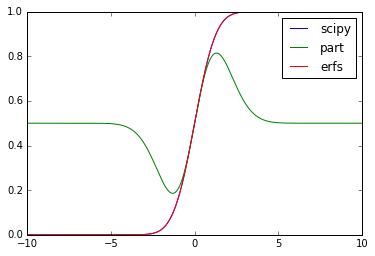

In [3]:
norms=stat.norm(0,1)

def fact2(n):
    return np.product(range(n,1,-2))
    
#def part_cdf(x,n=10):
#    return 0.5+norms.pdf(x)*sum([x**(2*i-1)/fact2(2*i-1) for i in range(1,n+1)])

def taylor_cdf(x,n=10):
    return 0.5+norms.pdf(0)*sum([((-1)**i/fact2(2*i))*x**(2*i+1) for i in range(0,n)])

def part_cdf_term(x,i):
    logt=(2*i-1)*np.log(np.abs(x))-sum([np.log(2*j-1) for j in range(1,2*i+1,2)])
    return np.exp(logt)*np.sign(x)

def part_cdf(x,n=10):
    return 0.5+norms.pdf(x)*sum([part_cdf_term(x,i) for i in range(1,n+1)])

def erfs(x):
    # erf(x/sqrt(2))
    b=[0,0.196854,0.115194,0.000344,0.019527]
    return 1-(1+sum([b[i]*x**i for i in range(1,5)]))**(-4)

def erf_cdf(x):
    return 0.5*(1+erfs(np.abs(x))*np.sign(x))

X=np.linspace(-10,10,1000)
plt.plot(X,stat.norm(0,1).cdf(np.linspace(-10,10,1000)),label="scipy")
#plt.plot(taylor1_cdf(np.linspace(-3,3,1000)))
plt.plot(X,part_cdf(X,n=10),label="part")
#plt.plot(taylor_cdf(np.linspace(-10,10,1000),n=1),label="taylor")
plt.plot(X,erf_cdf(X),label="erfs")
plt.legend()
plt.show()


In [4]:
X=[-1,-2,3]
print(np.abs(X))
print(np.sign(X))

[1 2 3]
[-1 -1  1]


看起来泰勒展开可能没有在整个R上收敛，所以还是用分部积分法吧。看得出仅取前十项就可以达到相当高的精度了。

### 分位数

分位数虽然可以用迭代法取得任意精度，但有趣的是一些十分简单的近似公式的存在，如这个山内近似公式(1965)

$$
u_a^\star \sim \sqrt{y(d-\frac{b}{y+c})} \\
y=-\ln(4a(a-a)) \\
b=5.7262204 \\
c=11.640595 \\
d=2.0611786 \\
$$

而$u_a$与$u_a^\star$的关系是(这个公式离线查不了公式打法暂时打不出来，见《统计计算》P59,大概就是p=0.5时直接取0，小于0.5时取$-u_a^\star$,大于0.5时取$u_{1-a}^\star$.

最大误差为$4.9 \times 10^{-4}$

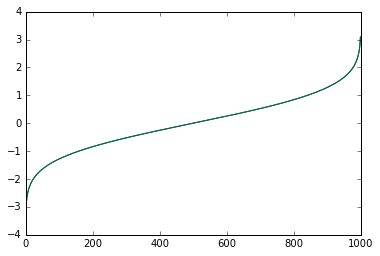

In [5]:
def star_ppf(p,func):
    try:
        if 0<p<0.5:
            return -func(p)
        elif p==0:
            return 0.5
        else:
            return func(1-p)
    except ValueError:
        return [star_ppf(pi,func) for pi in p]


def Shannei(a):
    y=-np.log(4*a*(1-a))
    b=5.7262204
    c=11.640595
    d=2.0611786
    return np.sqrt(y*(d-b/(y+c)))

X=np.linspace(0.001,0.999,1000)
plt.plot(norms.ppf(X))
plt.plot(star_ppf(X,Shannei))
plt.show()

下面让我们检查一下一般正态分布归结到标准正态分布的cdf,ppf公式是否正确。

$$
Y \sim N(\mu,\sigma) \\
F_Y(x)=\Phi(\frac{x-\mu}{\sigma}) \\
Q_Y(a)=\sigma Q(a)+\mu
$$
其中$\Phi(x)$是标准正态分布的cdf，而Q(a)则是标准正态分布的ppf。


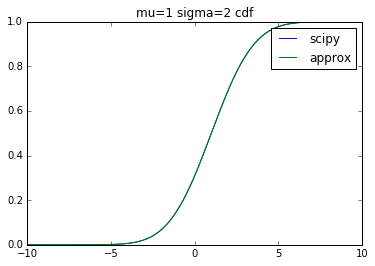

In [6]:
norms_cdf=erf_cdf
norms_ppf=lambda a:star_ppf(a,Shannei)

def norm_cdf(x,mu,sigma):
    return norms_cdf((x-mu)/sigma)

def norm_ppf(a,mu,sigma):
    return sigma*norms_ppf+mu

X=np.linspace(-10,10,1000)
mu=1
sigma=2
plt.plot(X,stat.norm(mu,sigma).cdf(X),label="scipy")
plt.plot(X,norm_cdf(X,mu,sigma),label="approx")
plt.title("mu={} sigma={} cdf".format(mu,sigma))
plt.legend()
plt.show()

### beta分布的数值计算

beta分布除了可以在$[0,1]$捏出各种分布以外，重要之处在于它可以通过换元表示了$t$,$F$,二项分布等分布。从而可以以类似不同参数正态分布与标准分布的关系一样作为求算的基础。

图例，beta分布捏出的各种形状的分布

$$
B(a,b)=\int_0^1t^{a-1}(1-t)^{b-1}dt \\
X \sim beta(a,b) \\
F_X(x)=\frac{1}{B(a,b)}\int_0^x t^{a-1}(1-t)^{b-1}dt
$$

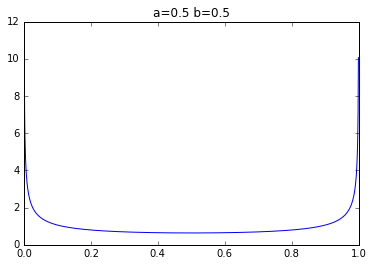

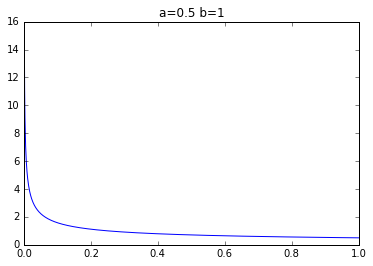

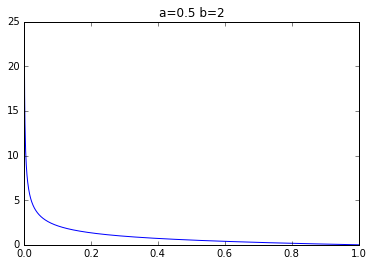

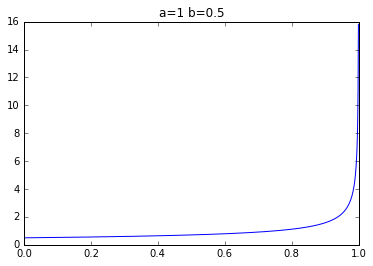

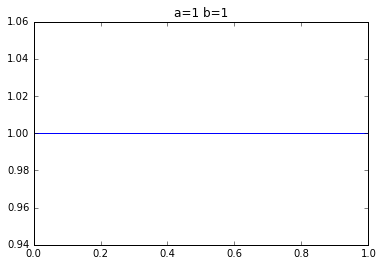

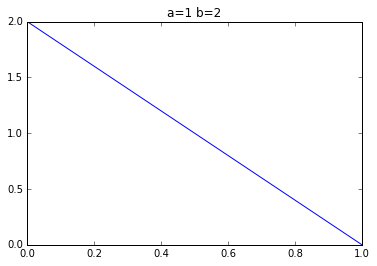

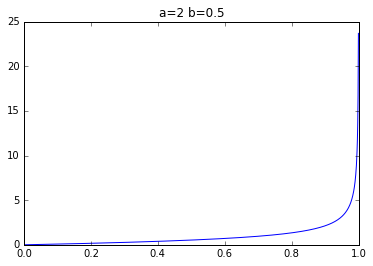

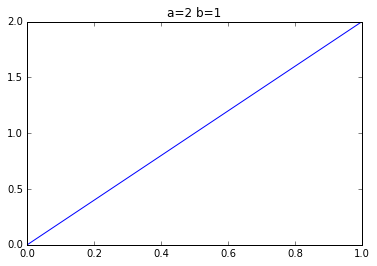

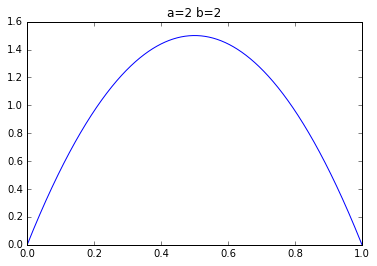

In [7]:
params=itertools.product([0.5,1,2],[0.5,1,2])
X=np.linspace(0,1,1000)
for param in params:
    plt.plot(X,stat.beta(*param).pdf(X))
    plt.title('a={} b={}'.format(*param))
    plt.show()

#### 伽马函数与beta积分，斯特林公式

beta分布族到处都是$\Gamma$函数。这个函数写成积分形式就表示它没有一般的初等表示，所幸，我们可以用斯特林公式直接获取其近似值回避数值积分:

$$
n! \sim \sqrt{2\pi n}\left( \frac{n}{e} \right)^n \\
\Gamma(z)=\sqrt{\frac{2\pi}{z}} \left(\frac{z}{e}\right) ^z \left( 1+O(\frac{1}{z}) \right) \approx  \sqrt{\frac{2\pi}{z}} \left(\frac{z}{e}\right) ^z\\
B(a,b)=B(b,a)=\frac{\Gamma(a)\Gamma(b)}{\Gamma(a+b)}
$$
如此就把这两个积分式纳入了高效数值计算梯队中

### F分布与beta分布

$$
X \sim F(m,n) \\
Y=\frac{mX}{n+mX} \sim Beta(\frac{m}{2},\frac{n}{2}) \\
F_X(x)=P(X<x)=P()
$$

$$
F_X(x)=P(X<x)=F_Y(x)=P(Y<x)=P(\frac{mX}{n+mX}<x)
$$

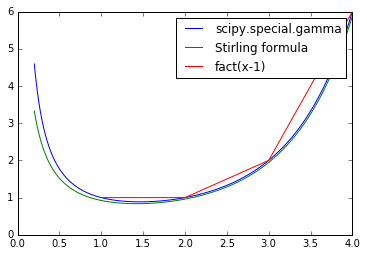

In [8]:
#三个公式的关系

def stirling_gamma(x):
    return np.sqrt(2*np.pi/x)*(x/np.e)**x

def fact(nl):
    return [np.product([i for i in np.arange(1,n+1)]) for n in nl]

X=np.linspace(0.2,4,1000)
Xi=np.array([0,1,2,3])
plt.plot(X,scipy.special.gamma(X),label="scipy.special.gamma")
plt.plot(X,stirling_gamma(X),label="Stirling formula ")
plt.plot(Xi+1,fact(Xi),label="fact(x-1)")
plt.legend()
plt.show()

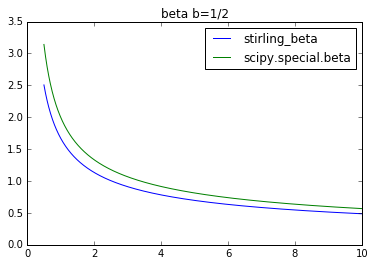

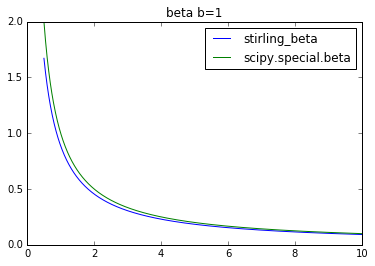

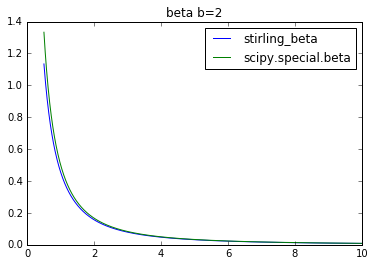

In [9]:
def stirling_beta(a,b):
    return stirling_gamma(a)*stirling_gamma(b)/stirling_gamma(a+b)

a=np.linspace(0.5,10,1000)
b=np.linspace(0.5,10,1000)

plt.plot(a,stirling_beta(a,1/2),label="stirling_beta")
plt.plot(a,scipy.special.beta(a,1/2),label="scipy.special.beta")
plt.title('beta b=1/2')
plt.legend()
plt.show()

plt.plot(a,stirling_beta(a,1),label="stirling_beta")
plt.plot(a,scipy.special.beta(a,1),label="scipy.special.beta")
plt.title('beta b=1')
plt.legend()
plt.show()

plt.plot(a,stirling_beta(a,2),label="stirling_beta")
plt.plot(a,scipy.special.beta(a,2),label="scipy.special.beta")
plt.title('beta b=2')
plt.legend()
plt.show()

第一个近似简直太糟了，这是gamma函数误差放大的结果，让我们换一个近似式

Gergő Nemes(2007)
$$
\Gamma(z) \approx \sqrt{\frac{2\pi}{z}} \left( \frac{1}{e} \left( z+\frac{1}{12z-\frac{1}{10z}}\right) \right)^z \\
$$

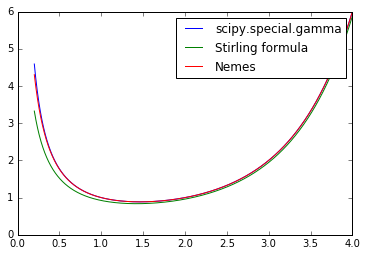

In [10]:
def Nemes_gamma(x):
    return np.sqrt(2*np.pi/x)*((1/np.e)*(x+1/(12*x-1/(10*x))))**x

X=np.linspace(0.2,4,1000)
plt.plot(X,scipy.special.gamma(X),label="scipy.special.gamma")
plt.plot(X,stirling_gamma(X),label="Stirling formula ")
plt.plot(X,Nemes_gamma(X),label="Nemes")
plt.legend()
plt.show()

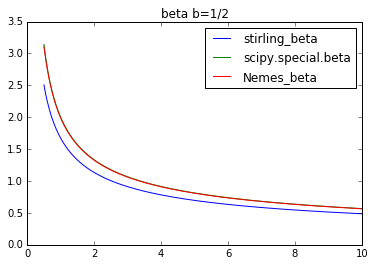

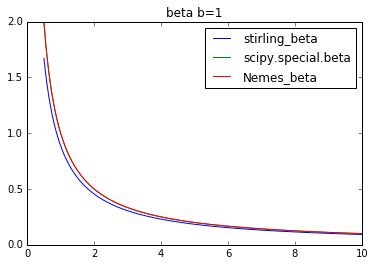

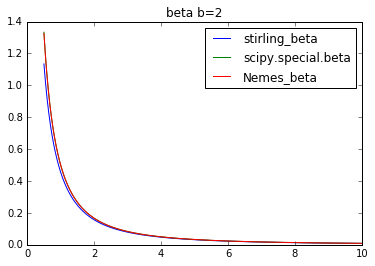

In [11]:
def Nemes_beta(a,b):
    return Nemes_gamma(a)*Nemes_gamma(b)/Nemes_gamma(a+b)

a=np.linspace(0.5,10,1000)
b=np.linspace(0.5,10,1000)

plt.plot(a,stirling_beta(a,1/2),label="stirling_beta")
plt.plot(a,scipy.special.beta(a,1/2),label="scipy.special.beta")
plt.plot(a,Nemes_beta(a,1/2),label="Nemes_beta")
plt.title('beta b=1/2')
plt.legend()
plt.show()

plt.plot(a,stirling_beta(a,1),label="stirling_beta")
plt.plot(a,scipy.special.beta(a,1),label="scipy.special.beta")
plt.plot(a,Nemes_beta(a,1),label="Nemes_beta")
plt.title('beta b=1')
plt.legend()
plt.show()

plt.plot(a,stirling_beta(a,2),label="stirling_beta")
plt.plot(a,scipy.special.beta(a,2),label="scipy.special.beta")
plt.plot(a,Nemes_beta(a,2),label="Nemes_beta")
plt.title('beta b=2')
plt.legend()
plt.show()

这是极好的，几乎看不出区别。

下面给出Beta(a,b)的分布函数$I_x(a,b)$的近似式，由分布积分法可先得级数表达式，然后化为连分数表达式。

$$
I_x(a,b)=\frac{\Gamma(a+b)x^a(1-x)^{b-1}}{\Gamma(a+1)\Gamma(b)} 
\left( 
\cfrac{1}{1+\cfrac{c_1}{1+\cfrac{c_2}{1+...}}}
\right) \\
$$
$$
c_{2k}=\frac{k(b-k)x}{(a+2k-1)(a+2k)} \tag{k=1,2,...}
$$
$$
c_{2k+1}=-\frac{(a+k)(a+b+k)x}{(a+2k)(a+2k+1)} \tag{k=1,2,...}
$$

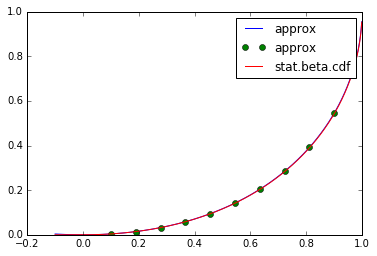

In [12]:
gamma=Nemes_gamma

def getc(n,x,a,b):
    if n==0:
        return 1
    elif n%2==0:
        k=n/2
        return (k*(b-k)*x)/((a+2*k-1)*(a+2*k))
    elif n%2==1:
        k=(n-1)/2
        return -((a+k)*(a+b+k)*x)/((a+2*k)*(a+2*k+1))
    
def cfrac(tl):
    if len(tl)==1:
        return tl[0]
    else:
        return tl[0]/(1+cfrac(tl[1:]))
        

def I(x,a,b,n=100,roll=True):
    if roll and x>=(a-1)/(a+b-2):
        return 1-I(1-x,b,a,n,roll=False)
    left=(gamma(a+b)*(x**a)*((1-x)**b))/(gamma(a+1)*gamma(b))
    right=cfrac([getc(i,x,a,b) for i in range(n+1)])
    #right=sum([getc(i,x,a,b) for i in range(n+1)])
    #print([getc(i,x,a,b) for i in range(n+1)])
    #print(left,right)
    return left*right

a=2
b=1/2
X=np.linspace(-0.1,0.999,1000)
points=np.linspace(0.1,0.9,10)
plt.plot(X,[I(x,a,b) for x in X],label="approx")
plt.plot(points,[I(x,a,b) for x in points],'o',label="approx")
plt.plot(X,stat.beta(a,b).cdf(X),label="stat.beta.cdf")
plt.legend()
plt.show()



貌似除了问题，先换一个分部积分法导出的级数形式看看

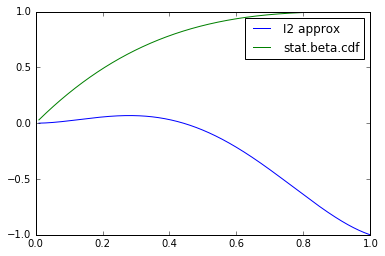

1346.70668868


In [13]:
beta=Nemes_beta

def I2_item(a,b,k):
    up=np.product([b-i for i in range(1,k+1)])
    down=-np.product([a+i for i in range(1,k+1)])
    return up/down

def I2(x,a,b,n=20):
    left=(x**2*(1-x)**(b-1))/(beta(a,b)*a)
    right=1+sum([(x/(1-x))**k*I2_item(a,b,k) for k in range(1,n+1)])
    return left*right
    
a=1
b=3
X=np.linspace(0.01,0.999,1000)
approxY=np.array([I2(x,a,b) for x in X])
statY=stat.beta(a,b).cdf(X)
plt.plot(X,approxY,label="I2 approx")
plt.plot(X,statY,label="stat.beta.cdf")
plt.legend()
plt.show()

print(np.sum((approxY-statY)**2))


In [14]:
I2(0.5,2,1)

0.25009677240300376

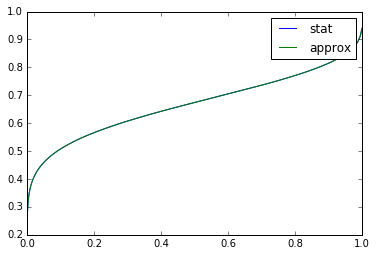

In [15]:
def two_div(f,a,b,epsilon=1e-4):
    while True:
        test=(a+b)/2
        if b-a<epsilon:
            return test
        if f(test)==0:
            return test
        elif f(test)>0:
            a,b=a,test
        else:
            a,b=test,b
    
def beta_ppf(p,a,b):
    return two_div(lambda x:I(x,a,b)-p,0,1)

a=10
b=5
X=np.linspace(0.001,0.999,1000)
plt.plot(X,stat.beta(a,b).ppf(X),label="stat")
plt.plot(X,[beta_ppf(p,a,b) for p in X],label="approx")
plt.legend()
plt.show()

In [17]:
def U(x,a,b):
    return (1/beta(a,b))*(x**a)*((1-x)**b)

def I3(x,a,b):
    #这里直接返回1,1/2特殊情况的值，递归定义，用来资瓷t分布和F分布
    if a==1/2 and b==1/2:
        #print(1)
        return 1-(2/np.pi)*np.arctan(np.sqrt((1-x)/x))
    elif a==1/2 and b==1:
        #print(2)
        return np.sqrt(x)
    elif a==1 and b==1/2:
        #print(3)
        return 1-np.sqrt(1-x)
    elif a==1 and b==1:
        #print(4)
        return x
    elif a>1:
        return I3(x,a-1,b)-(1/(a-1))*U(x,a-1,b)
    elif b>1:
        return I3(x,a,b-1)+(1/(b-1))*U(x,a,b-1)
    else:
        assert Exception("number vaild?")
        


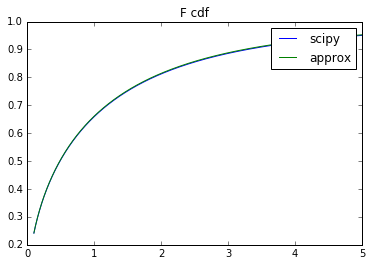

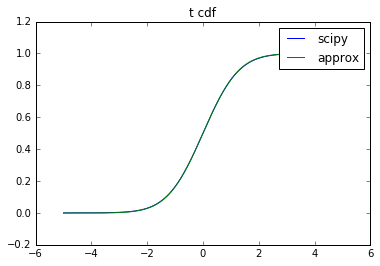

In [18]:
beta_cdf=I3
beta_ppf=beta_ppf

def F_cdf_beta(x,m,n):
    y=(m*x)/(n+m*x)
    return beta_cdf(y,m/2,n/2)

def t_cdf_beta(t,n):
    x=n/(n+t**2)
    if t==0:
        return 0.5
    elif t>0:
        return 1-0.5*beta_cdf(x,n/2,1/2)
    else:
        return 0.5*beta_cdf(x,n/2,1/2)
    
F_m=1
F_n=10
n=20

X=np.linspace(0.1,5,1000)
plt.plot(X,stat.f(F_m,F_n).cdf(X),label="scipy")
plt.plot(X,[F_cdf_beta(x,F_m,F_n) for x in X],label="approx")
plt.title("F cdf")
plt.legend()
plt.show()

X=np.linspace(-5,5,1000)
plt.plot(X,stat.t(n).cdf(X),label="scipy")
plt.plot(X,[t_cdf_beta(x,n) for x in X],label="approx")
plt.title("t cdf")
plt.legend()
plt.show()

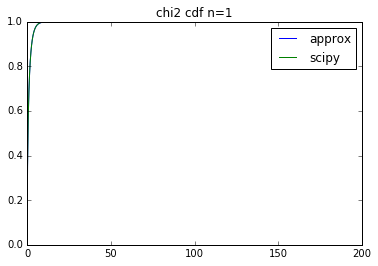

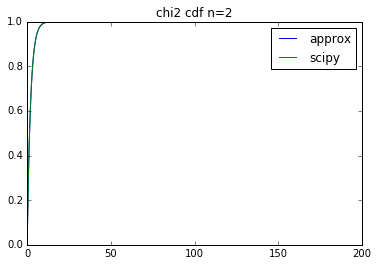

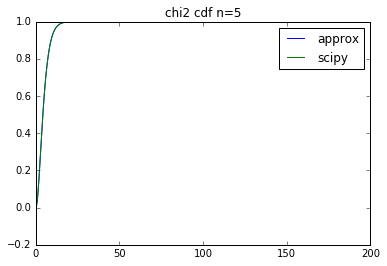

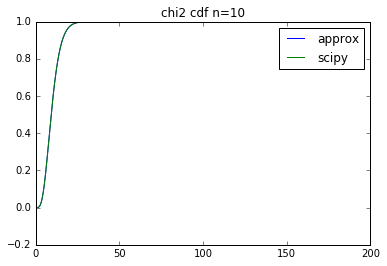

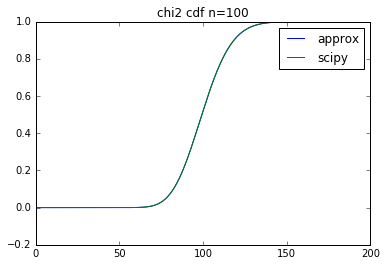

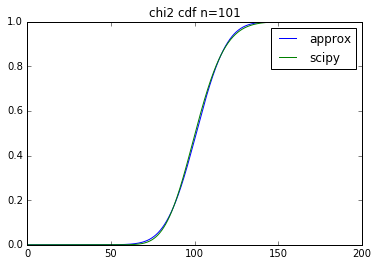

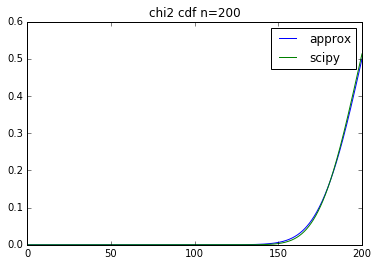

In [19]:
gamma=Nemes_gamma
norms_cdf=erf_cdf

def chi2_f(x,n):
    return (1/(2*gamma(n/2)))*(x/2)**(n/2-1)*np.exp(-x/2)

def chi2_cdf(x,n):
    if n>100:
        return norms_cdf((x-n)/np.sqrt(2*n))
    elif n==1:
        return 2*norms_cdf(np.sqrt(x))-1
    elif n==2:
        return 1-np.exp(-x/2)
    else:
        return chi2_cdf(x,n-2)-2*chi2_f(x,n)
    
X=np.linspace(0.01,200,1000)
for n in [1,2,5,10,100,101,200]:
    plt.plot(X,chi2_cdf(X,n),label="approx")
    plt.plot(X,stat.chi2(n).cdf(X),label="scipy")
    plt.title('chi2 cdf n={}'.format(n))
    plt.legend()
    plt.show()

In [20]:
stat.t.cdf?

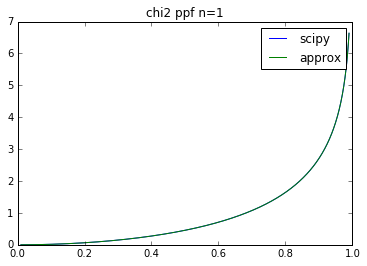

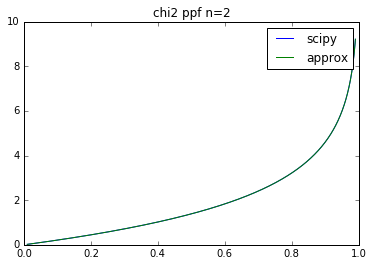

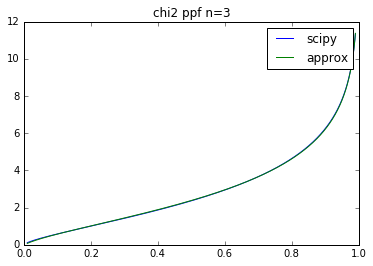

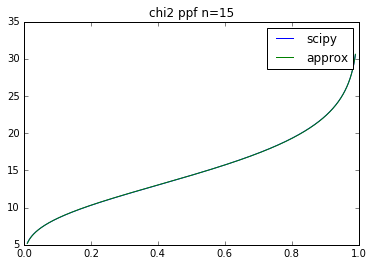

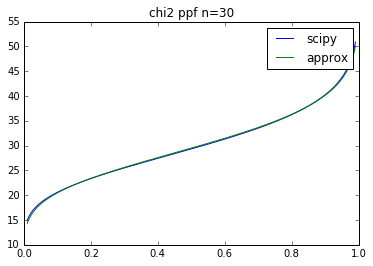

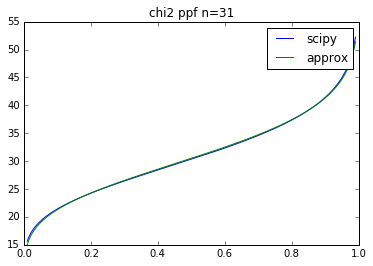

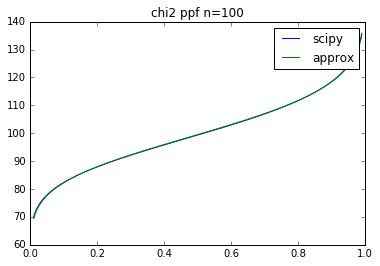

In [21]:
def chi2_ppf(p,n):
    if n==1:
        pstar=(p+1)/2
        return norms.ppf(pstar)**2
    elif n==2:
        return -2*np.log(1-p)
    elif n<30:
        return n*(1-2/(9*n)+norms.ppf(p)*np.sqrt(2/(9*n)))**3
    else:
        return (1/2)*(norms.ppf(p)+np.sqrt(2*n-1))**2
    
X=np.linspace(0.01,0.99,1000)

for n in [1,2,3,15,30,31,100]:
    plt.plot(X,stat.chi2(n).ppf(X),label="scipy")
    plt.plot(X,chi2_ppf(X,n),label="approx")
    plt.title('chi2 ppf n={}'.format(n))
    plt.legend()
    plt.show()
        

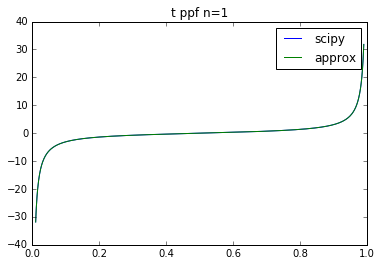

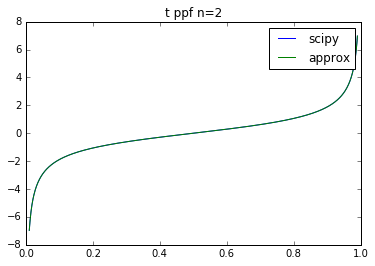

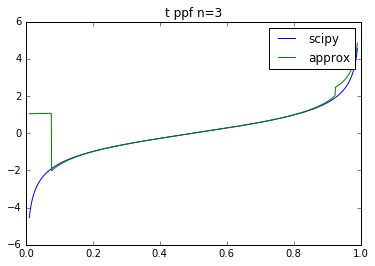

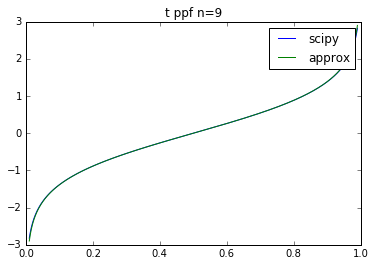

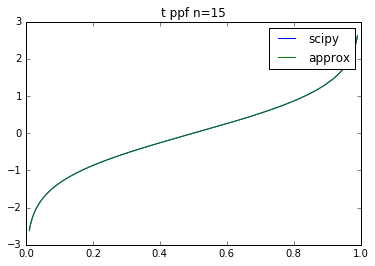

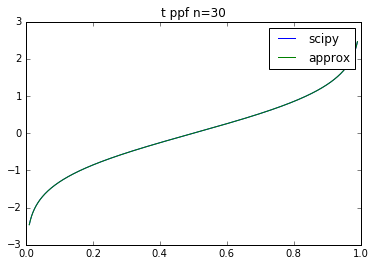

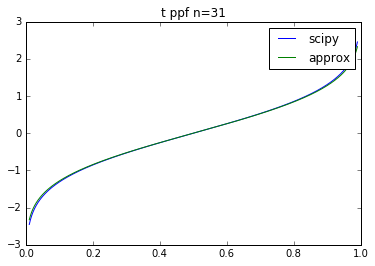

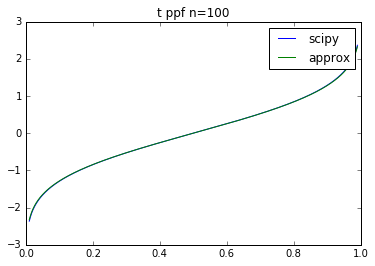

In [22]:
def t_ppf(p,n):
    if n==1:
        return np.tan(np.pi*(p-1/2))
    elif n==2:
        return (np.sqrt(2)*(2*p-1))/(np.sqrt(1-(2*p-1)**2))
    elif n<=30:
        A=(1-1/(4*n))**2-norms.ppf(p)**2/(2*n)
        if A>0.5:
            return A**(-1/2)*norms.ppf(p)
        else:
            return np.sqrt(n)*(gamma((n+1)/2)/(np.sqrt(n)*(1-p)*gamma(n/2)*n))**(1/n)
    else:
        return norms.ppf(p)
    
X=np.linspace(0.01,0.99,1000)
for n in [1,2,3,9,15,30,31,100]:
    plt.plot(X,stat.t(n).ppf(X),label="scipy")
    plt.plot(X,[t_ppf(x,n) for x in X],label="approx")
    plt.title('t ppf n={}'.format(n))
    plt.legend()
    plt.show()

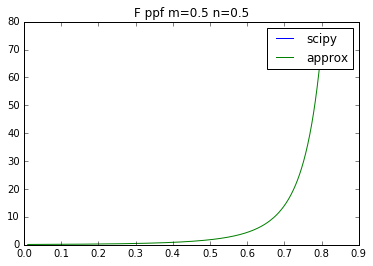

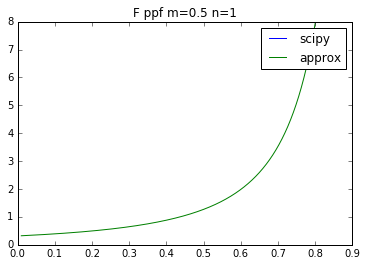

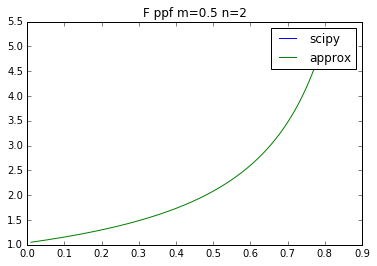

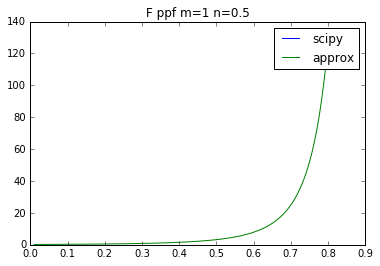

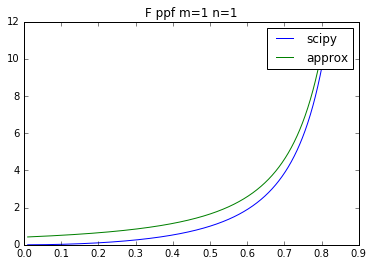

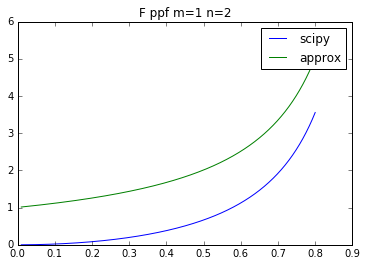

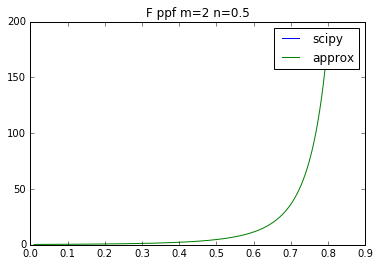

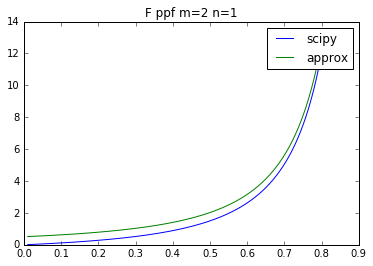

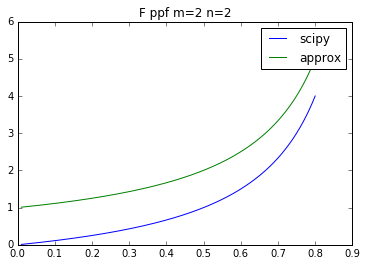

In [55]:
def F_ppf(p,m,n):
    a=2/(9*m)
    b=2/(9*n)
    B=(1-b)**2-b*norms.ppf(p)**2
    up=norms.ppf(p)
    if B>0.8:
        #print("B>0.8")
        lefttop=(1-a)*(1-b)
        righttop=up*np.sqrt((1-a)**2*b+(1-b)**2*a-a*b*up**3)
        down=(1-b)**2-b*up**2
        return ((lefttop+righttop)/down)**3
    else:
        #print('B<=0.8')
        left=1/beta(m/2,n/2)
        mid=(2*n**(n/2-1))/(m**(n/2)) # 可能是m不是n
        right=1/(1-p)
        return (left*mid*right)**(2/n)

X=np.linspace(0.01,0.8,1000)
for m,n in itertools.product(*[[1/2,1,2]]*2):
    plt.plot(X,stat.f(m,n).ppf(X),label="scipy")
    plt.plot(X,[F_ppf(x,m,n) for x in X],label="approx")
    plt.title('F ppf m={} n={}'.format(m,n))
    plt.legend()
    plt.show()

In [47]:
stat.normaltest(norms.ppf(np.random.random(size=1000)))

NormaltestResult(statistic=0.32980462627259566, pvalue=0.84797653621036018)

In [40]:
stat.normaltest(stat.norm(0,1).rvs(size=1000))

NormaltestResult(statistic=4.59224843192293, pvalue=0.10064817935206179)

(array([   3.,    9.,   12.,   26.,   36.,   65.,  105.,  123.,  132.,
         114.,  124.,  100.,   65.,   32.,   25.,   15.,    8.,    4.,
           0.,    2.]),
 array([-2.99523115, -2.66493632, -2.3346415 , -2.00434667, -1.67405185,
        -1.34375703, -1.0134622 , -0.68316738, -0.35287255, -0.02257773,
         0.3077171 ,  0.63801192,  0.96830675,  1.29860157,  1.6288964 ,
         1.95919122,  2.28948605,  2.61978087,  2.9500757 ,  3.28037052,
         3.61066535]),
 <a list of 20 Patch objects>)

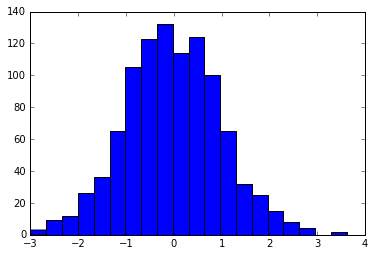

In [51]:
plt.hist(norms.ppf(np.random.random(size=1000)),bins=20)